In [2]:
!pip install qutip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 8.5 MB/s eta 0:00:00


In [3]:
from qutip import * # * means that we imported all the functions.
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib import cm

Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.5871784 +0.j          0.26144953+0.10870503j -0.13078761+0.01488778j]
 [ 0.26144953-0.10870503j  0.36296695+0.j         -0.06721221+0.02930496j]
 [-0.13078761-0.01488778j -0.06721221-0.02930496j  0.04985465+0.j        ]]
Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.          1.          1.        ]
 [ 1.         -0.99189648  0.        ]
 [ 1.          0.          4.59189648]]


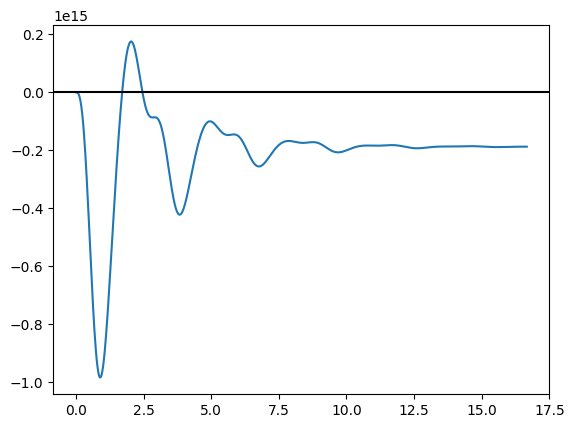

In [7]:
#  \     /  |3>
#   \   /
#    \ /
# ---------
#    / \
#   /   \
#  /     \  |2>
#
#
#
#  -------- |1>

N=3
c=3.0e8
B=0.0020376144036248545    #magnetic field
v=10
g=1            #landé factor
#hbar=1.05457182e-34
hbar=1
omega0=3e15  #transition frequency between the ground and excited states in the abscence of shifts
Omega2=1e8     #interaction strength with the 1->2 laser
Omega3=1e8
Omega=1e8   #interaction strength with the 1->3 laser
Gamma=6.0e7
omegalaser=omega0-3*Gamma
muBohr=9.274e-24
muBohr*=1/1.05457182e-34  #as hbar=1 mubohr

redi=1e-8 #time redimensioning constant

Delta2=-3*Gamma+g*muBohr*B+hbar*v*omegalaser/c
Delta3=-3*Gamma-g*muBohr*B-hbar*v*omegalaser/c

H=Qobj([[0,hbar*Omega2*redi,hbar*Omega3*redi],[hbar*Omega2*redi,-Delta2*redi,0],[hbar*Omega3*redi,0,-Delta3*redi]])

times = np.linspace(0, 10.0, 1000)
I11=Qobj([[1,0,0],[0,0,0],[0,0,0]])  #|1><1|  |l=0 m=0><l=0 m=0| ---->  |l=0 m=0>=vert(1,0,0)
I22=Qobj([[0,0,0],[0,1,0],[0,0,0]])
I33=Qobj([[0,0,0],[0,0,0],[0,0,1]])  #|3><3|  |l=1 m=1><l=1 m=1|          |l=1 m=1>=vert(0,0,1)
I12=Qobj([[0,1,0],[0,0,0],[0,0,0]])
I13=Qobj([[0,0,1],[0,0,0],[0,0,0]])

Decay12=Qobj([[0,np.sqrt(Gamma*redi),0],[0,0,0],[0,0,0]])   # c= |1><2|
Decay13=Qobj([[0,0,np.sqrt(Gamma*redi)],[0,0,0],[0,0,0]])
Force=-1j*(omegalaser*hbar/c)*Qobj([[0,Omega2,-Omega3],[-Omega2,0,0],[Omega3,0,0]])

psi0 = basis(3, 0)  #

times = np.linspace(0.0, 10/(Gamma*redi), 1000)

result = mesolve(H, psi0, times, [Decay12,Decay13],[I22,I33,Force])  # si se lo pones, te devuelve <Force(times)>
resultt = mesolve(H, psi0, times, [Decay12,Decay13])   # si no te devolve rho(times)  traza(F*rho)
rho_final = resultt.states[-1]

print(rho_final)

#plt.plot(times, result.expect[0])
plt.plot(times, result.expect[2]);
print(H)
plt.axhline(0, color='black')

errooooor
3.0970452087017133


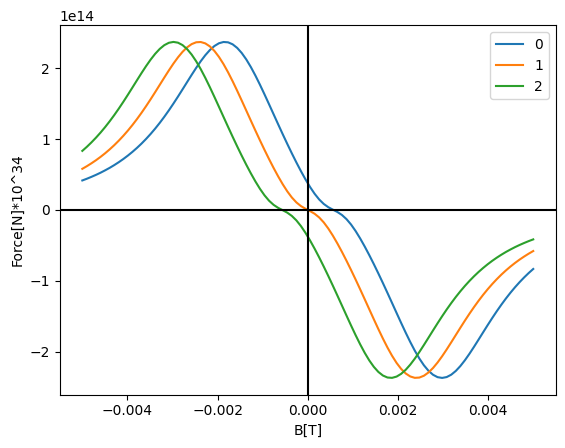

In [10]:
#now I want to see the force as a function of the magnetic field
timesteps=100

times = np.linspace(0.0, 30, timesteps)
Brange= np.linspace(-50e-4, 50e-4, timesteps)
Frange= np.zeros(timesteps)
ii=0
k=0
vrange=np.linspace(-5,5,3)
plt.xlabel("B[T]")
plt.ylabel("Force[N]*10^34")
for v in vrange:
  ii=0
  for B in Brange:
    Delta2=hbar*(omegalaser-omega0)+g*muBohr*B+hbar*v*omegalaser/c
    Delta3=hbar*(omegalaser-omega0)-g*muBohr*B-hbar*v*omegalaser/c
    H=Qobj([[0,hbar*Omega2*redi,hbar*Omega3*redi],[hbar*Omega2*redi,-Delta2*redi,0],[hbar*Omega3*redi,0,-Delta3*redi]])
    result = mesolve(H, psi0, times, [Decay12,Decay13],[Force])
    Frange[ii]=result.expect[0][timesteps-1]
    ii+=1
  plt.plot(Brange, Frange)
plt.legend(["0", "1", "2", "3", "4"])
print(Delta2*redi)
plt.axhline(0, color='black')
plt.axvline(0, color='black')

In [ ]:
B=3e-4/0.01 #Magnetic field per length is 3Gauss per centimeter
class Atom:
  def __init__(self,x0,y0,z0,Vx0,Vy0,Vz0,m0,Fx0,Fy0,Fz0,rho0: Qobj):
      self.rho=rho0
      self.m=m0
      self.r=np.array([x0,y0,z0])
      self.V=np.array([Vx0,Vy0,Vz0])
      self.F=np.array([Fx0,Fy0,Fz0])
  def BorreFuerza(self):
    self.F=np.array([0,0,0])
  def Muevase(self,dt):
    self.V=self.V+dt*(self.F*1e-34/self.m) ##where we include the planck constant, so the acceleration has magnitude of 10^6 or 10^5 or something similar
    self.r=self.r+dt*self.V
  def CalculateForce(self,dt):
    times = np.linspace(0.0, dt/redi, timesteps)
    Delta2=hbar*(omegalaser-omega0)+g*muBohr*B*self.r[0]+hbar*self.V[0]*omegalaser/c
    Delta3=hbar*(omegalaser-omega0)-g*muBohr*B*self.r[0]-hbar*self.V[0]*omegalaser/c
    H=Qobj([[0,hbar*Omega2*redi,hbar*Omega3*redi],[hbar*Omega3*redi,-Delta2*redi,0],[hbar*Omega3*redi,0,-Delta3*redi]])
    result = mesolve(H, self.rho, times, [Decay12,Decay13],[Force])
    self.F[0]=1*result.expect[0][timesteps-1]


In [ ]:
Sodio=Atom(-0.1,0,0,50,0,0,3.817e-26,0,0,0,rho0=Qobj([[1,0,0],[0,0,0],[0,0,0]]))
tmax=0.001
Nsteps=1000
dt=tmax/Nsteps
Sodio.CalculateForce(dt)
Sodio.Muevase(dt)
print(Sodio.F)
print(Sodio.r)
Sodio.CalculateForce(dt)
Sodio.Muevase(dt)
print(Sodio.F)
print(Sodio.r)
Sodio.CalculateForce(dt)
Sodio.Muevase(dt)
print(Sodio.F)
print(Sodio.r)

[-229080767156280                0                0]
[-0.0999506  0.         0.       ]
[-232438737091076                0                0]
[-0.09990181  0.          0.        ]
[-234996064472666                0                0]
[-0.09985363  0.          0.        ]


Now time dependent

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.        +0.j          0.69670667-0.71735613j -0.94222232-0.33498821j]
 [ 0.69670667+0.71735613j -3.55071464+0.j          0.        +0.j        ]
 [-0.94222232+0.33498821j  0.        +0.j          3.55071464+0.j        ]]


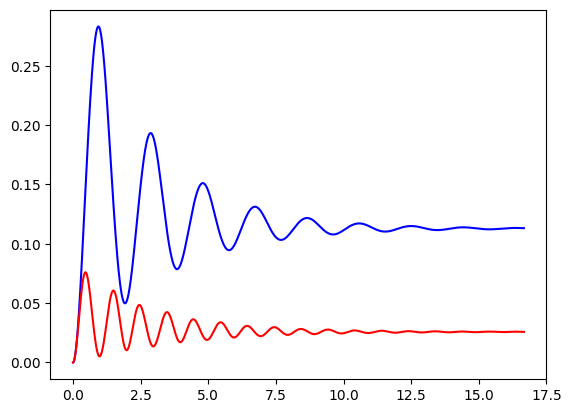

In [ ]:
#  \     /  |3>
#   \   /
#    \ /
# ---------
#    / \
#   /   \
#  /     \  |2>
#
#
#
#  -------- |1>

I11=Qobj([[1,0,0],[0,0,0],[0,0,0]])
I22=Qobj([[0,0,0],[0,1,0],[0,0,0]])
I33=Qobj([[0,0,0],[0,0,0],[0,0,1]])
I12=Qobj([[0,1,0],[0,0,0],[0,0,0]])
I13=Qobj([[0,0,1],[0,0,0],[0,0,0]])
Decay12=Qobj([[0,np.sqrt(Gamma*redi),0],[0,0,0],[0,0,0]])
Decay13=Qobj([[0,0,np.sqrt(Gamma*redi)],[0,0,0],[0,0,0]])

BB=0.0040376144036248545    #magnetic field
vv=10
omega1=-3*Gamma+vv*omegalaser/c
omega3=-3*Gamma-vv*omegalaser/c

def Hamiltonian(t,args):
  dip=Qobj([[0,Omega2*redi*np.exp(1j*(omega1*redi)*t),Omega3*redi*np.exp(1j*(omega3*redi)*t)],[Omega2*redi*np.exp(-1j*(omega1*redi)*t),0,0],[Omega3*redi*np.exp(-1j*(omega3*redi)*t),0,0]])
  Zeem=redi*Qobj([[0,0,0],[0,-g*BB*muBohr,0],[0,0,g*BB*muBohr]])
  return dip+Zeem

def ForceFunc(t,args):
  F=-1j*(omegalaser*hbar/c)*Qobj([[0,Omega2*np.exp(1j*(omega1*redi)*t),-Omega3*np.exp(1j*(omega3*redi)*t)],[-Omega2*np.exp(-1j*(omega1*redi)*t),0,0],[Omega3*np.exp(-1j*(omega3*redi)*t),0,0]])
  return F


psi0 = basis(3, 0)

times = np.linspace(0.0, 10/(Gamma*redi), 1000)
args={}
print(Hamiltonian(1,args))
result2 = mesolve(Hamiltonian, psi0, times, [Decay12,Decay13],[I22,I33], options=Options(nsteps=20000))

plt.plot(times, result2.expect[0],color="blue")
plt.plot(times, result2.expect[1],color="red")



errooooor
2.7507145778344246


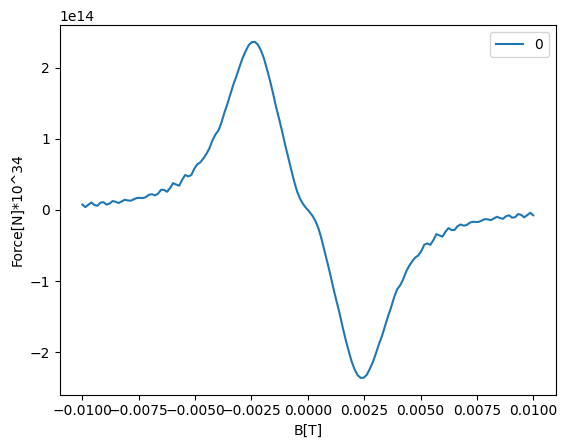

In [ ]:
#now I want to see the force as a function of the magnetic field
timesteps=60

times = np.linspace(0.0, 15, timesteps)
args={}
Bsteps=150
Brange= np.linspace(-100e-4, 100e-4, Bsteps)
Frange= np.zeros(Bsteps)
ii=0
k=0
vrange=np.linspace(-0,0,1)
plt.xlabel("B[T]")
plt.ylabel("Force[N]*10^34")

for vv in vrange:
  ii=0
  for BB in Brange:
    omega1=-3*Gamma+vv*omegalaser/c
    omega3=-3*Gamma-vv*omegalaser/c
    F=ForceFunc(15,args)
    result3 = mesolve(Hamiltonian, psi0, times, [Decay12,Decay13],[F],options=Options(nsteps=20000))
    Frange[ii]=result3.expect[0][timesteps-1]
    ii+=1
    if(Delta2>0):
      if(k==0):
        print("errooooor")
        k=1
  plt.plot(Brange, Frange)
plt.legend(["0", "1", "2"])
print(Delta2*redi)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.74555841-2.45411938e-17j -0.03297973-3.31090727e-01j
   0.05273529+1.34955775e-01j]
 [-0.03297973+3.31090727e-01j  0.21718293+3.06440763e-17j
  -0.06503005+1.61976854e-02j]
 [ 0.05273529-1.34955775e-01j -0.06503005-1.61976854e-02j
   0.03725867-1.47880570e-17j]]
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.74555841-2.45411938e-17j -0.03297973-3.31090727e-01j
   0.05273529+1.34955775e-01j]
 [-0.03297973+3.31090727e-01j  0.21718293+3.06440763e-17j
  -0.06503005+1.61976854e-02j]
 [ 0.05273529-1.34955775e-01j -0.06503005-1.61976854e-02j
   0.03725867-1.47880570e-17j]]


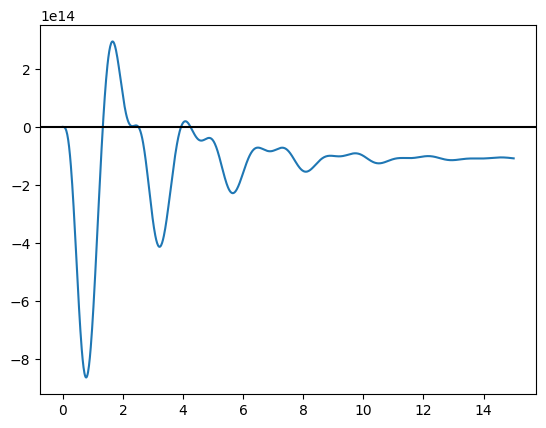

In [ ]:
timesteps=1000

vv=0
BB=0.0040376144036248545

omega1=-3*Gamma+vv*omegalaser/c
omega3=-3*Gamma-vv*omegalaser/c
times = np.linspace(0.0, 15, timesteps)
resultrho = mesolve(Hamiltonian, psi0, times, [Decay12,Decay13], options=Options(nsteps=20000))

Ftrange=np.linspace(0,15,timesteps,dtype=complex)
kk=0

for t in times:
  Op=ForceFunc(t,args)*resultrho.states[kk]
  Ftrange[kk]=Op.tr()
  kk+=1

print(resultrho.states[-1])
print(resultrho.states[timesteps-1])
plt.plot(times,Ftrange)
plt.axhline(0, color='black')

now the third different way of defining a time dependent Hamiltonian

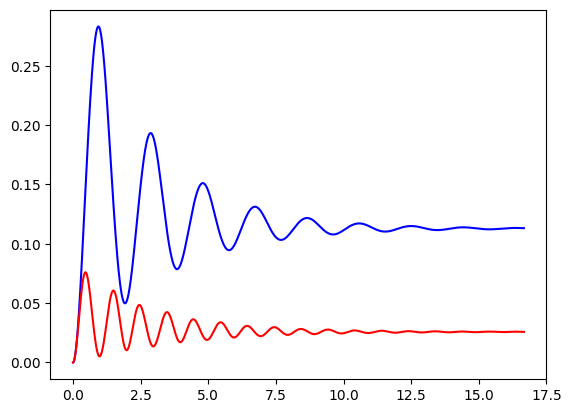

In [ ]:
#  \     /  |3>
#   \   /
#    \ /
# ---------
#    / \
#   /   \
#  /     \  |2>
#
#
#
#  -------- |1>

I11=Qobj([[1,0,0],[0,0,0],[0,0,0]])
I22=Qobj([[0,0,0],[0,1,0],[0,0,0]])
I33=Qobj([[0,0,0],[0,0,0],[0,0,1]])
I12=Qobj([[0,1,0],[0,0,0],[0,0,0]])
I13=Qobj([[0,0,1],[0,0,0],[0,0,0]])
Decay12=Qobj([[0,np.sqrt(Gamma*redi),0],[0,0,0],[0,0,0]])
Decay13=Qobj([[0,0,np.sqrt(Gamma*redi)],[0,0,0],[0,0,0]])
BBB=0.0040376144036248545    #magnetic field
vvv=10

args = {
        "Bz": BBB,
        "omegalaser1z": -3*Gamma+vvv*omegalaser/c,
        "omegalaser3z": -3*Gamma-vvv*omegalaser/c,
        }
def Coeff12(t,args):
  return Omega*redi*np.exp(1j*(args["omegalaser1z"]*redi)*t)
def Coeff21(t,args):
  return Omega*redi*np.exp(-1j*(args["omegalaser1z"]*redi)*t)
def Coeff13(t,args):
  return Omega*redi*np.exp(1j*(args["omegalaser3z"]*redi)*t)
def Coeff31(t,args):
  return Omega*redi*np.exp(-1j*(args["omegalaser3z"]*redi)*t)
Zeem=redi*Qobj([[0,0,0],[0,-g*args["Bz"]*muBohr,0],[0,0,g*args["Bz"]*muBohr]])

Hamil=[Zeem,[I12.dag(),Coeff21],[I12,Coeff12],[I13.dag(),Coeff31],[I13,Coeff13]]

times = np.linspace(0.0, 10/(Gamma*redi), 1000)
psi0 = basis(3, 0)
resultado = mesolve(Hamil, psi0, times, [Decay12,Decay13],[I22,I33],args=args)

plt.plot(times, resultado.expect[0],color="blue")
plt.plot(times, resultado.expect[1],color="red")



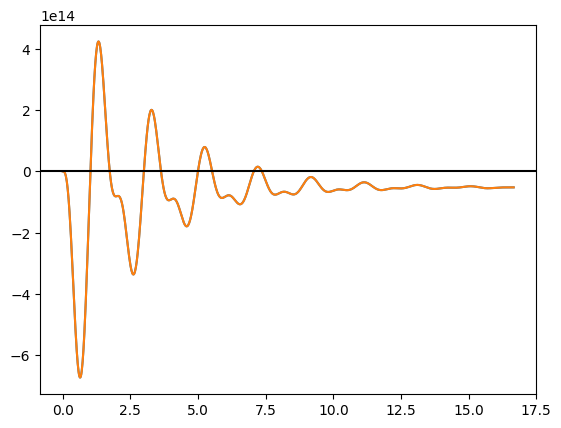

In [ ]:
timesteps=1000

times = np.linspace(0.0, 10/(Gamma*redi), timesteps)
resultrho = mesolve(Hamil, psi0, times, [Decay12,Decay13], args=args,options=Options(nsteps=20000))

Ftrange=np.linspace(0,10/(Gamma*redi),timesteps,dtype=complex)
kk=0
vvv=10
omega1=-3*Gamma+vvv*omegalaser/c
omega3=-3*Gamma-vvv*omegalaser/c
def ForceFunc2(t,args):
  F=-1j*(omegalaser*hbar/c)*Qobj([[0,Omega2*np.exp(1j*(omega1*redi)*t),-Omega3*np.exp(1j*(omega3*redi)*t)],[-Omega2*np.exp(-1j*(omega1*redi)*t),0,0],[Omega3*np.exp(-1j*(omega3*redi)*t),0,0]])
  return F
for t in times:
  Op=ForceFunc2(t,args)*resultrho.states[kk]
  Ftrange[kk]=Op.tr()
  kk+=1

plt.plot(times,Ftrange)
plt.plot(times,result.expect[2])
plt.axhline(0, color='black')

2.7507145778344246


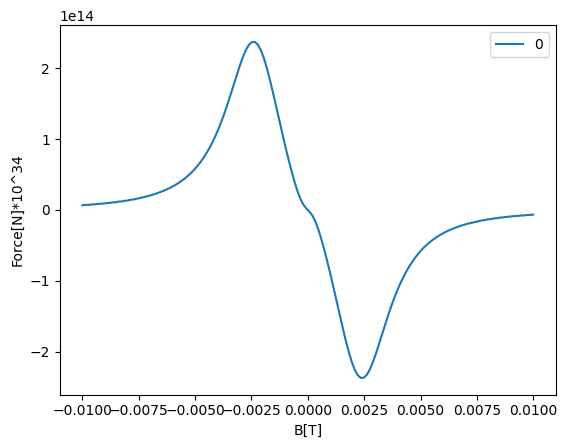

In [ ]:
tmax=25
times = np.linspace(0.0, tmax, timesteps)

Bsteps=150
Brange= np.linspace(-100e-4, 100e-4, Bsteps)
Frange= np.zeros(Bsteps)
ii=0
k=0
vrange=np.linspace(-0,0,1)
plt.xlabel("B[T]")
plt.ylabel("Force[N]*10^34")


for vv in vrange:
  ii=0
  args["omegalaser1z"]= -3*Gamma+vv*omegalaser/c
  args["omegalaser3z"]= -3*Gamma-vv*omegalaser/c
  for BB in Brange:
    args["Bz"]= BB
    F=ForceFunc2(tmax,args)
    Zeem=redi*Qobj([[0,0,0],[0,-g*args["Bz"]*muBohr,0],[0,0,g*args["Bz"]*muBohr]])
    Hamil=[Zeem,[I12.dag(),Coeff21],[I12,Coeff12],[I13.dag(),Coeff31],[I13,Coeff13]]
    result = mesolve(Hamil, psi0, times, [Decay12,Decay13],[F],args=args)
    Frange[ii]=result.expect[0][timesteps-1]
    ii+=1
  plt.plot(Brange, Frange)
plt.legend(["0", "1", "2"])
print(Delta2*redi)

In [ ]:
np.linspace(0,5,5)

array([0.  , 1.25, 2.5 , 3.75, 5.  ])